In [363]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display

plt.style.use('Joey')

import numpy as np
import pandas as pd
import scipy.stats as sps
import datetime as dt

import mossbauer
import utils as u

from scipy.integrate import simpson, quad, quad_vec
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.stats import norm
from matplotlib import gridspec


from scipy.ndimage import gaussian_filter

from os.path import join

from tqdm import tqdm

In [359]:
source = CobaltRhodiumMatrix(activity=1.7e8)  # default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
#absorber = AlphaIron(abundance=0.02, thickness_microns=10)
absorber = PotassiumFerrocyanide()

### measurement parameters
PMT_OD = 5  # mm
PMT_distance = 14  # mm
measurement_parameters = dict(
    acquisition_time=23.7*2*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=2400.0,
    detection_efficiency=0.85,  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
)

#with Si drift detector and 50mCi source, and Fe57:

PMT_OD = 4 #1.75 * 25.4  # mm
PMT_distance = 10  # mm
measurement_parameters = dict(
    acquisition_time=23.7*2*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=0,
    detection_efficiency = 0.9 #0.4  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss_siDet = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
)




#with Si drift detector and 50mCi:
source2 = CobaltRhodiumMatrix()# default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
source2.total_activity = 100e-3* 3.7e10 *0.0916
absorber = PotassiumFerrocyanide()

PMT_OD = 4 #1.75 * 25.4  # mm
PMT_distance = 10  # mm
measurement_parameters = dict(
    acquisition_time=23.7*30*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=0,
    detection_efficiency = 0.9 #0.4  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss_siDet_hotsource = mossbauer.MossbauerMeasurement(
    source2,
    absorber,
    measurement_parameters
)



#with Si drift detector hotsource and and Fe57 absorber:

pos = np.array([-5.48, -3.25, -1.01, 0.66, 2.90, 5.13])  # from Violet and Pipcorn 1971
pos = pos - np.mean(pos)
split_ratio = (3, 2, 1, 1, 2, 3)
offset = 0
Eres = pos + offset
natural_linewidth = 4.55e-9  # eV
source_activity = 3.7e10 * 100e-3  # Hz
mossbauer_relative_intensity = 0.0916
source3 = dict(
    Eres=Eres,
    transition_coefficients=np.asarray(split_ratio, dtype=float)/np.sum(split_ratio),
    linewidth=mossbauer.E_to_vel(natural_linewidth),
    total_activity=mossbauer_relative_intensity * source_activity
)


absorber2 = AlphaIron(abundance = 1, thickness_microns = 0.360)

PMT_OD = 4 #1.75 * 25.4  # mm
PMT_distance = 10  # mm
measurement_parameters = dict(
    acquisition_time=23.7*30*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=0,
    detection_efficiency = 0.9 #0.4  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss_siDet_hotsource_Fe57 = mossbauer.MossbauerMeasurement(
    source3,
    absorber2,
    measurement_parameters
)


{'activity': 170000000.0}
{}
0.0180871353675058


63.705001141335124

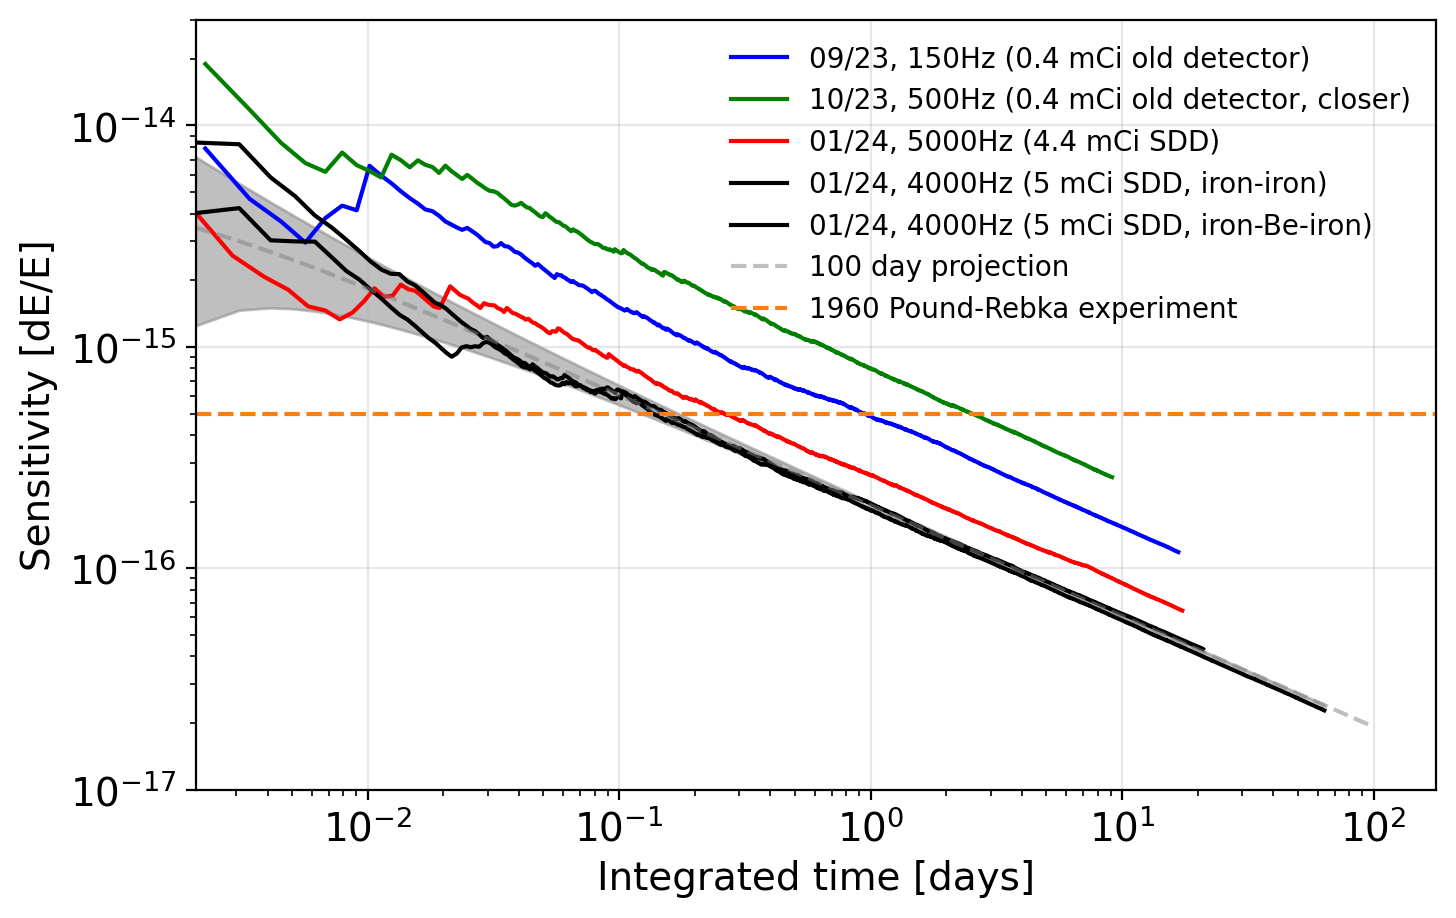

In [376]:
t1, scan1 = np.loadtxt(datadir+'20230901_scan/FeCy_0.25_mms_2steps_0.6-17in_clean_sensitivityvstime.dat')
t2, scan2 = np.loadtxt(datadir+'20231012_scan/FeCy_0.25_mms_2steps_0.6-7in_clean_sensitivityvstime.dat')
t3, scan3 = np.loadtxt(datadir+'20231231_scan/FeCy_0.25_mms_2steps_0.5-1in_clean_sensitivityvstime.dat')
t4, scan4 = np.loadtxt(datadir+'20240122_scan//Fe20um_Al200um_4steps_2in_clean_sensitivityvstime.dat')
t5, scan5 = np.loadtxt(datadir+'20240220_scan//Fe20um_1BeBlank_4steps_1in_clean_sensitivityvstime.dat')

plt.loglog(t1/3600/24, scan1, color = 'b', label = '09/23, 0.4 mCi, NaI scintillator, )')#150 Hz
plt.loglog(t2/3600/24, scan2, color = 'g', label = '10/23, 0.4 mCi old detector, closer)')#500 Hz
plt.loglog(t3/3600/24, scan3, color = 'r', label = '01/24, 4.4 mCi SDD)')#5000 Hz
plt.loglog(t4/3600/24, scan4, color = 'k', label = '01/24, 5 mCi SDD, iron-iron)')#4000 Hz
plt.loglog(t5/3600/24, scan5, color = 'k', label = '01/24, 5 mCi SDD, iron-Be-iron)') #4000 Hz




dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])
R1 = moss.transmitted_spectrum(v1)
R2 = moss.transmitted_spectrum(v2)
dRdE_diff = dRdE_v1 - dRdE_v2
dt = t5[0]/2
N = np.arange(len(t5))+2
std = 6e-15

plt.fill_between(t5/3600/24,std*(1/np.sqrt(N)-1/N),std*(1/np.sqrt(N)+1/N),color='gray', alpha = 0.5)
##plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)
t100d = np.arange(0,100*24*3600,dt)
Nt = np.arange(len(t100d))+1
plt.plot(t100d/3600/24, std/np.sqrt(Nt), color = 'gray', linestyle = '--', alpha = 0.5, label = '100 day projection')
#theory = mossbauer.vel_to_E(mossbauer.ratetime_to_deltaEmin(time, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
#plt.loglog(t3/3600/24, rootNscaling, 'gray', linewidth =1 , label = '$1/\sqrt{N}$')
#plt.fill_between(time, theory*(1-1/np.sqrt(n)), theory*(1+1/np.sqrt(n)), color='gray',alpha = 0.5)
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3
#print('current sensitivity: {:.4e}'.format(mossbauer.vel_to_E(dEmin_diff[-1])))
plt.xlim(180/24/3600,)
plt.ylim(1e-17,3e-14)
plt.axhline(5e-16, color = 'C1',linestyle = '--' ,label = '1960 Pound-Rebka experiment')
plt.ylabel('Sensitivity [dE/E]')
plt.xlabel('Integrated time [days]')
plt.legend(loc = 'best',frameon=False, fontsize  = 10)

t5[-1]/3600/24

63.705001141335124

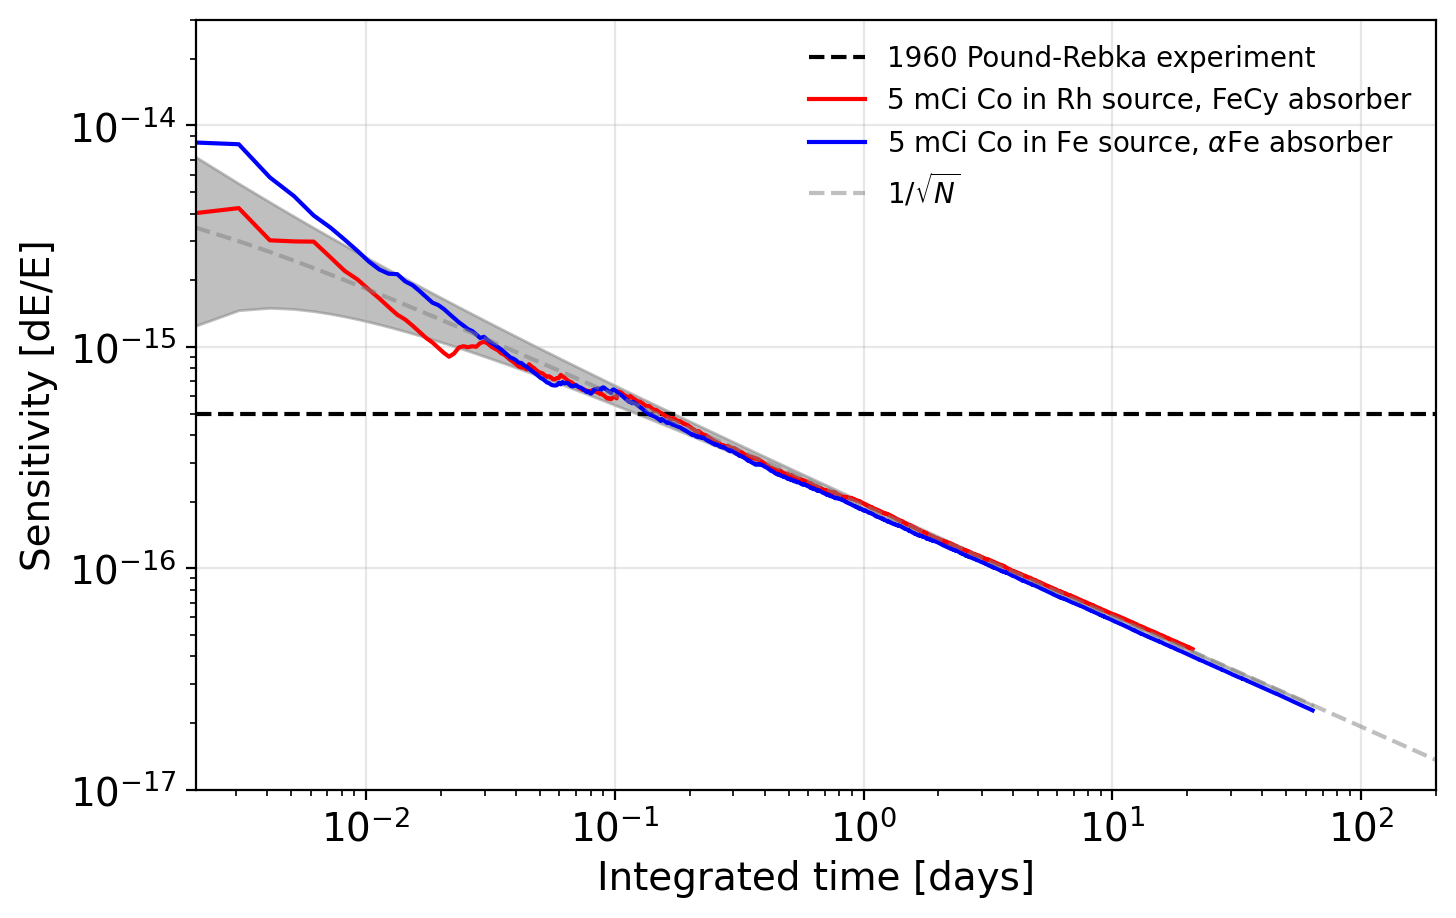

In [395]:
t1, scan1 = np.loadtxt(datadir+'20230901_scan/FeCy_0.25_mms_2steps_0.6-17in_clean_sensitivityvstime.dat')
t2, scan2 = np.loadtxt(datadir+'20231012_scan/FeCy_0.25_mms_2steps_0.6-7in_clean_sensitivityvstime.dat')
t3, scan3 = np.loadtxt(datadir+'20231231_scan/FeCy_0.25_mms_2steps_0.5-1in_clean_sensitivityvstime.dat')
t4, scan4 = np.loadtxt(datadir+'20240122_scan//Fe20um_Al200um_4steps_2in_clean_sensitivityvstime.dat')
t5, scan5 = np.loadtxt(datadir+'20240220_scan//Fe20um_1BeBlank_4steps_1in_clean_sensitivityvstime.dat')

#plt.loglog(t1/3600/24, scan1, color = 'b', label = '09/23, 0.4 mCi, NaI scintillator, )')#150 Hz
#plt.loglog(t2/3600/24, scan2, color = 'g', label = '10/23, 0.4 mCi old detector, closer)')#500 Hz
#plt.loglog(t3/3600/24, scan3, color = 'r', label = '01/24, 4.4 mCi Silicon detector)')#5000 Hz


plt.axhline(5e-16, color = 'k',linestyle = '--' ,label = '1960 Pound-Rebka experiment')
plt.loglog(t4/3600/24, scan4, color = 'r', label = '5 mCi Co in Rh source, FeCy absorber')#4000 Hz
plt.loglog(t5/3600/24, scan5, color = 'b', label = r'5 mCi Co in Fe source, $\alpha$Fe absorber') #4000 Hz




dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])
R1 = moss.transmitted_spectrum(v1)
R2 = moss.transmitted_spectrum(v2)
dRdE_diff = dRdE_v1 - dRdE_v2
dt = t5[0]/2
N = np.arange(len(t5))+2
std = 6e-15

plt.fill_between(t5/3600/24,std*(1/np.sqrt(N)-1/N),std*(1/np.sqrt(N)+1/N),color='gray', alpha = 0.5)
##plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)
t100d = np.arange(0,300*24*3600,dt)
Nt = np.arange(len(t100d))+1
plt.plot(t100d/3600/24, std/np.sqrt(Nt), color = 'gray', linestyle = '--', alpha = 0.5, label = r'$1/\sqrt{N}$')
#theory = mossbauer.vel_to_E(mossbauer.ratetime_to_deltaEmin(time, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
#plt.loglog(t3/3600/24, rootNscaling, 'gray', linewidth =1 , label = '$1/\sqrt{N}$')
#plt.fill_between(time, theory*(1-1/np.sqrt(n)), theory*(1+1/np.sqrt(n)), color='gray',alpha = 0.5)
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3
#print('current sensitivity: {:.4e}'.format(mossbauer.vel_to_E(dEmin_diff[-1])))
plt.xlim(180/24/3600,200)
plt.ylim(1e-17,3e-14)

plt.ylabel('Sensitivity [dE/E]')
plt.xlabel('Integrated time [days]')
plt.legend(loc = 'best',frameon=False, fontsize  = 10)

t5[-1]/3600/24

In [309]:
np.sqrt((R1+R2)*t3[0]/2)/t3[0]/dRdE_diff/3e11
18/4
fname[-2:]

t4[0]/2, np.arange(0,100*24*3600,dt)/24/3600

(88.90592813491821, 99.99858907582583)

current sensitivity: 4.9993e-16


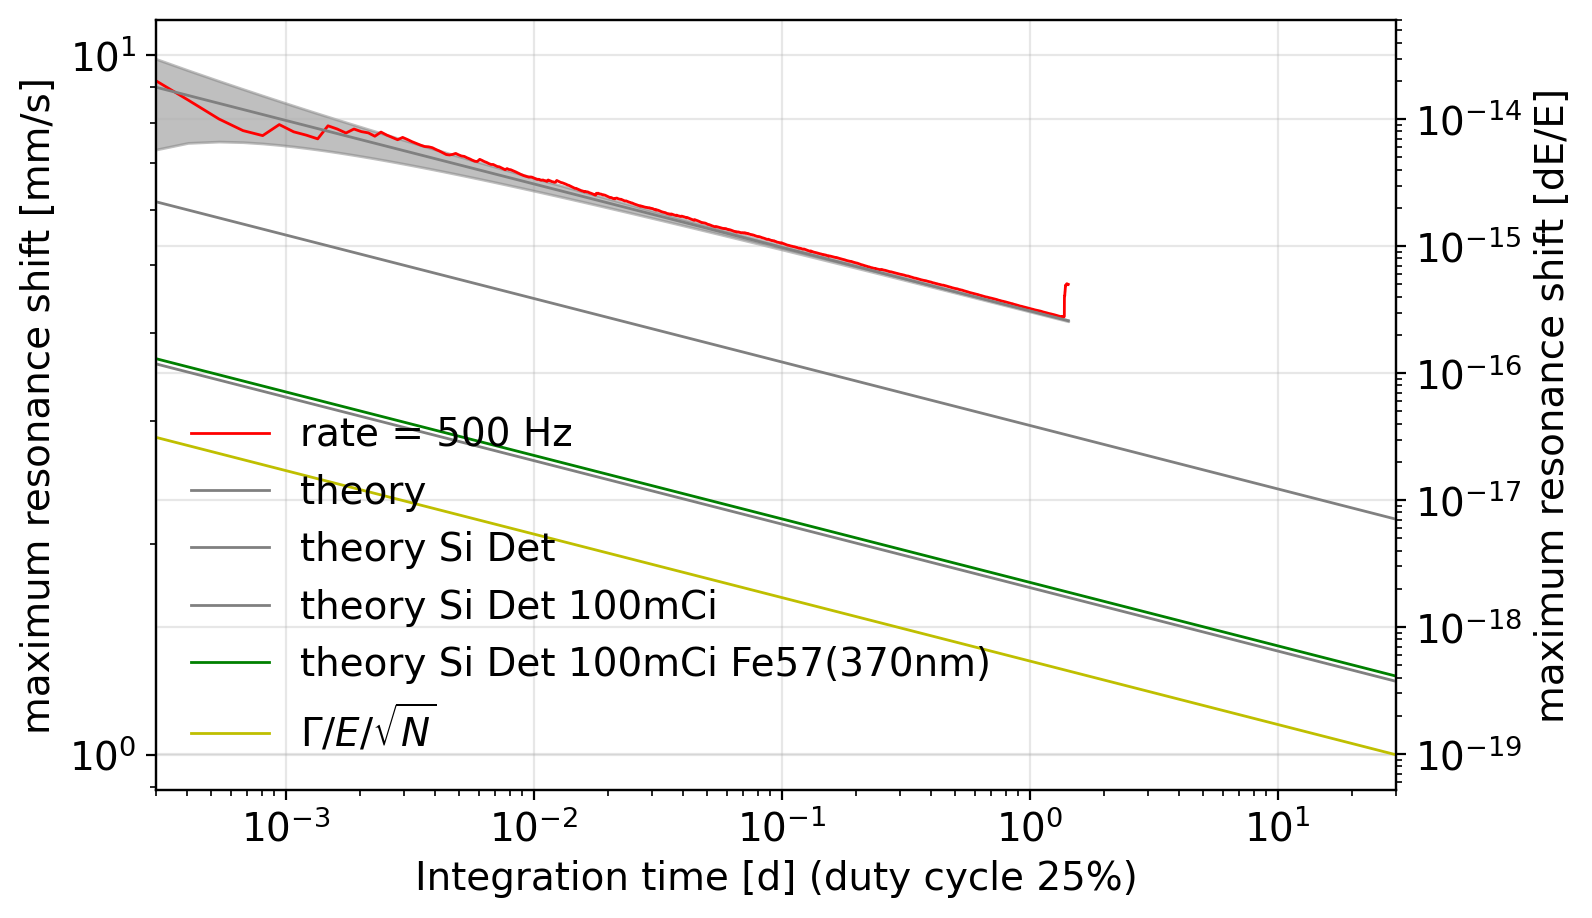

4.110352543131885e-19

In [32]:
idx1=0
idx2=-1

datadir = '/home/mossbauer/Data/mossbauer_data/'


fname0 = '20231005_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname1 = '20231009_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname2 = '20231012_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname3 = '20231017_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'

fnames = [fname0, fname1,fname2,fname3]
#fnames = [fname2]

#carefu, channels are inverted!
v1 = -0.2321399999999999
v2 = -0.08586

dataframes = []
for fname in fnames:
    datatemp = pd.read_csv(join(datadir, fname))
    dataframes.append(datatemp)

data = pd.concat(dataframes)
data = data[idx1:idx2]
datav1 = data[data['nominal_velocity']==-v1].reset_index()
datav2 = data[data['nominal_velocity']==-v2].reset_index()

minlen = min(len(datav1['count']),len(datav2['count']))

datav1 = datav1[:minlen]
datav2 = datav2[:minlen]
    

    
sigma_rate_v1 = (datav1['count']/datav1['DAQ_time']).expanding().std().values[1:]
sigma_rate_v2 = (datav2['count']/datav2['DAQ_time']).expanding().std().values[1:]
sigma_rate_diff = ((datav1['count']/datav1['DAQ_time']-datav2['count']/datav2['DAQ_time'])).expanding().std().values[1:]

n = datav1.reset_index().index.values[1:]+1

delta_rate_v1 = sigma_rate_v1/np.sqrt(n)
delta_rate_v2 = sigma_rate_v2/np.sqrt(n)
delta_rate_diff = sigma_rate_diff/np.sqrt(n)

dt = datav1['DAQ_time'][1]/3600/24
time = n*dt
time_integration = n*datav1['DAQ_time'][1]
time_theory = np.linspace(10,30*24*3600)


fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

vels = np.linspace(-1,1,10000)

dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])
dRdE_diff = dRdE_v1 - dRdE_v2


dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)


#ax.loglog(time, dEmin_v1, 'w--',label = 'single point -')
#ax2.loglog(time, mossbauer.vel_to_E(dEmin_v1)/14e3, 'k--',label = 'single point 1')
#ax2.loglog(time, mossbauer.vel_to_E(dEmin_v2)/14e3, 'k--',label = 'single point 2')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_diff)/14.4e3, 'r',linewidth = 1,label = 'rate = 500 Hz')
#ax2.loglog(time_old, mossbauer.vel_to_E(dEmin_diff_old)/14.4e3, 'r--',linewidth = 1 ,label = 'rate = 150 Hz')

R1 = moss.transmitted_spectrum(v1)
R2 = moss.transmitted_spectrum(v2)


theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_integration, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
ax2.loglog(time, theory, 'gray', linewidth =1 , label = 'theory')
plt.fill_between(time, theory*(1-1/np.sqrt(n)), theory*(1+1/np.sqrt(n)), color='gray',alpha = 0.5)
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3
print('current sensitivity: {:.4e}'.format(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3))


#Expected improvements:Si Det

dRdE_v1 = moss_siDet.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss_siDet.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])
dRdE_diff = dRdE_v1 - dRdE_v2
dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)
R1 = moss_siDet.transmitted_spectrum(v1)
R2 = moss_siDet.transmitted_spectrum(v2)
theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_theory, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
ax2.loglog(time_theory/24/3600, theory, 'gray', linewidth =1 , label = 'theory Si Det')
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3


#Hot source

dRdE_v1 = moss_siDet_hotsource.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss_siDet_hotsource.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])

dRdE_diff = dRdE_v1 - dRdE_v2
dRdE_diff_old = dRdE_diff 
dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)
R1 = moss_siDet_hotsource.transmitted_spectrum(v1)
R2 = moss_siDet_hotsource.transmitted_spectrum(v2)
theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_theory, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
ax2.loglog(time_theory/24/3600, theory, 'gray', linewidth =1 , label = 'theory Si Det 100mCi')
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3


#SI det Hot source Fe57
v1 = -0.1
v2 = 0.1
dv = 0.01

dRdE_v1 = (moss_siDet_hotsource_Fe57.transmitted_spectrum(v1-dv/2)-moss_siDet_hotsource_Fe57.transmitted_spectrum(v1+dv/2))/dv
dRdE_v2 = (moss_siDet_hotsource_Fe57.transmitted_spectrum(v2-dv/2)-moss_siDet_hotsource_Fe57.transmitted_spectrum(v2+dv/2))/dv
dRdE_diff = dRdE_v1 - dRdE_v2
dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)
R1 = moss_siDet_hotsource_Fe57.transmitted_spectrum(v1)
R2 = moss_siDet_hotsource_Fe57.transmitted_spectrum(v2)
theory = mossbauer.vel_to_E( mossbauer.ratetime_to_deltaEmin(time_theory, np.abs(R1+R2),np.abs(dRdE_diff)))/14.4e3
ax2.loglog(time_theory/24/3600, theory, 'g', linewidth =1 , label = 'theory Si Det 100mCi Fe57(370nm)')
#ax2.axhline(mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3)#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3
ax2.loglog(time_theory/24/3600, 5e-9/14.4e3/np.sqrt(time_theory*(R1+R2)), 'y', linewidth =1 , label = '$\Gamma/E/\sqrt{N}$')



ax2.set_yscale('log')
ax.set_yscale('log')
#plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)


plt.xlabel('integration time [h]')
ax.set_ylabel('maximum resonance shift [mm/s]')
#ax2.set_ylim(1e-19,3e-14)
ax.set_xlim(3e-4,3e1)
ax2.set_ylabel('maximum resonance shift [dE/E]')





#ax2.axhline(3.55e-16)
plt.legend(loc = 'best',frameon=False)
ax.set_xlabel('Integration time [d] (duty cycle 25%)')
plt.show()


theory[-1]#, 4.4e-9/np.sqrt(40*23*3600)/14.4e3



In [33]:
R1

2388222.4724051454

In [225]:
np.linspace(0, 2., 33) 

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
       1.5   , 1.5625, 1.625 , 1.6875, 1.75  , 1.8125, 1.875 , 1.9375,
       2.    ])

In [264]:
int(20/(2/0.14)), int(20/(2/0.16))

(1, 1)

In [247]:
2/0.16, 

12.5

In [256]:
1/0.1875

5.333333333333333